<h1 style="color: #3a75c4;">Model Evaluation For Heart Failure Prediction</h1>

<h2 style="color: #75aadb;">00 | Libraries</h2>

In [1]:
# 📚 Basic libraries
import pandas as pd
import numpy as np 

# 🤖 Machine Learning
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# File system libraries
import os
import sys

# Add the root directory to sys.path 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Project libraries
import utils.viz as viz
import utils.classification_model as cm

# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings

<h2 style="color: #75aadb;">01 | Data Extraction</h2>

In [2]:
# Extract the clean data cvs
data = pd.read_csv('../datasets/clean_heart_disease.csv')
hd_df = data.copy()

In [3]:
hd_df

,age,sex,restingbp,cholesterol,fastingbs,maxhr,exerciseangina,oldpeak,chestpaintype_ASY,chestpaintype_ATA,chestpaintype_NAP,chestpaintype_TA,restingecg_LVH,restingecg_Normal,restingecg_ST,st_slope_Down,st_slope_Flat,st_slope_Up,heartdisease
0,40,0,140,289,0,172,0,0.0,0,1,0,0,0,1,0,0,0,1,0
1,49,1,160,180,0,156,0,1.0,0,0,1,0,0,1,0,0,1,0,1
2,37,0,130,283,0,98,0,0.0,0,1,0,0,0,0,1,0,0,1,0
3,48,1,138,214,0,108,1,1.5,1,0,0,0,0,1,0,0,1,0,1
4,54,0,150,195,0,122,0,0.0,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,110,264,0,132,0,1.2,0,0,0,1,0,1,0,0,1,0,1
914,68,0,144,193,1,141,0,3.4,1,0,0,0,0,1,0,0,1,0,1
915,57,0,130,131,0,115,1,1.2,1,0,0,0,0,1,0,0,1,0,1
916,57,1,130,236,0,174,0,0.0,0,1,0,0,1,0,0,0,1,0,1


<h2 style="color: #75aadb;">05 | Modeling: Classification</h2>

<h3 style="color: #f4e287;">X-y Split </h3>

In [4]:
# X and y Split
X = hd_df.drop("heartdisease", axis=1)
y = hd_df["heartdisease"]

<h3 style="color: #f4e287;">Train-Test Split </h3>

In [5]:
# Split the data into train and test sets with a test size of 0.1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

<h3 style="color: #f4e287;">Data Preprocessing: Feature Scaling </h3>

In [6]:
# Define continuous columns and binary columns
continuous_columns = ['age', 'restingbp', 'cholesterol', 'maxhr', 'oldpeak']
binary_columns = ['sex',
                  'fastingbs',
                  'exerciseangina', 
                  'chestpaintype_ASY',
                  'chestpaintype_ATA', 
                  'chestpaintype_NAP', 
                  'chestpaintype_TA',
                  'restingecg_LVH',
                  'restingecg_Normal',
                  'restingecg_ST',
                  'st_slope_Down',
                  'st_slope_Flat',
                  'st_slope_Up']

In [7]:
# Create ColumnTransformer to apply StandardScaler just to continuous variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_columns),   # Scale continuous variables
        ('bin', 'passthrough', binary_columns)            # Leave binary variables as they are
    ])

# Create a SMOTE object for oversampling
smote = SMOTE(sampling_strategy='minority')

<h3 style="color: #f4e287;"> Baseline model vs SMOTE and Standardization</h3>

In [8]:
# Baseline model: Logistic Regression
model = SVC()
model.fit(X_train, y_train)

SVC()

In [9]:
y_pred_baseline = model.predict(X_test)
print("Test Set Evaluation for Baseline Model:")
print(classification_report(y_test, y_pred_baseline))

Test Set Evaluation for Baseline Model:
              precision    recall  f1-score   support

           0       0.60      0.63      0.62        38
           1       0.73      0.70      0.72        54

    accuracy                           0.67        92
   macro avg       0.67      0.67      0.67        92
weighted avg       0.68      0.67      0.68        92



In [10]:
# Let's apply SMOTE and StandardScaler to the Logistic Regression model
# Create a pipeline that includes both preprocessing and the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('classifier', model)  # Add the classifier
    ])
            
# Apply SMOTE manually inside the loop during training
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Now fit the model on the entire resampled training set (using the pipeline)
pipeline.fit(X_resampled, y_resampled)

# After training, make predictions on the test set
y_pred_better = pipeline.predict(X_test)

# Evaluate the performance on the test set (outside of cross-validation)
print("Test Set Evaluation SMOTE and StandardScaler:")
print(classification_report(y_test, y_pred_better))

Test Set Evaluation SMOTE and StandardScaler:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        38
           1       0.86      0.93      0.89        54

    accuracy                           0.87        92
   macro avg       0.87      0.86      0.86        92
weighted avg       0.87      0.87      0.87        92



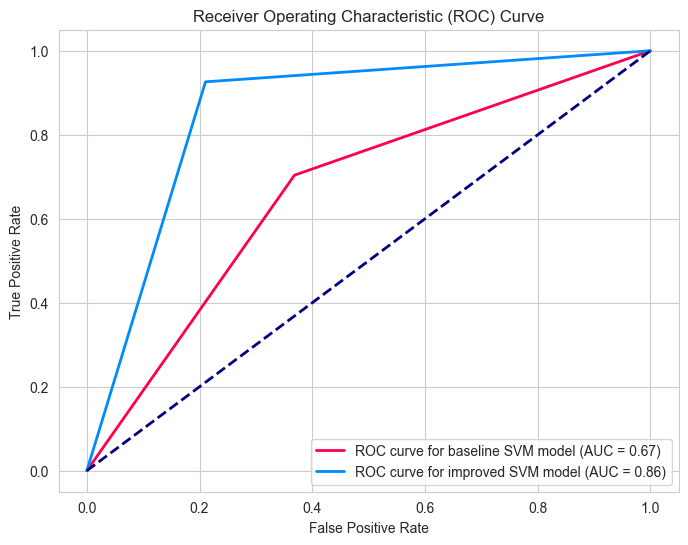

In [11]:
# Compare the ROC curve for each model
# Set the labels
label1 = 'ROC curve for baseline SVM model'
label2 = 'ROC curve for improved SVM model'

# Plot the ROC curve
viz.roc_curve_auc_plot(y_test, y_pred_baseline, y_test, y_pred_better,label1, label2)

- SVMs can be heavily impacted by **imbalanced data** because they tend to prioritize the majority class, resulting in poor performance on the minority class.

- SVM models benefit from **standardized data** because they rely on distance-based methods, and unstandardized data can lead to biased models that give more importance to features with larger scales.

- For all of that, our imporved model perfurms much better than the baseline.

<h3 style="color: #f4e287;">Selecting the Model </h3>

I will compare different models to see which one fits better to the dataset:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Support Vector Machine (SVM)

In [12]:
# Define the models you want to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': SVC()
}

# Evaluate the models performance using cross-validation
cm.model_evaluation(models, preprocessor, smote, X_train, y_train)


📈 Evaluating with 3-fold cross-validation:

	Logistic Regression Average Accuracy: 0.8613 ± 0.0187
	Decision Tree Average Accuracy: 0.7985 ± 0.0024


	Random Forest Average Accuracy: 0.8546 ± 0.0117
	XGBoost Average Accuracy: 0.8590 ± 0.0120
	SVM Average Accuracy: 0.8734 ± 0.0201

📈 Evaluating with 5-fold cross-validation:

	Logistic Regression Average Accuracy: 0.8580 ± 0.0407
	Decision Tree Average Accuracy: 0.7742 ± 0.0238
	Random Forest Average Accuracy: 0.8645 ± 0.0284
	XGBoost Average Accuracy: 0.8624 ± 0.0388
	SVM Average Accuracy: 0.8679 ± 0.0348

📈 Evaluating with 8-fold cross-validation:

	Logistic Regression Average Accuracy: 0.8612 ± 0.0332
	Decision Tree Average Accuracy: 0.8018 ± 0.0444
	Random Forest Average Accuracy: 0.8668 ± 0.0360
	XGBoost Average Accuracy: 0.8623 ± 0.0421
	SVM Average Accuracy: 0.8711 ± 0.0290

📈 Evaluating with 10-fold cross-validation:

	Logistic Regression Average Accuracy: 0.8658 ± 0.0477
	Decision Tree Average Accuracy: 0.7964 ± 0.0350
	Random Forest Average Accuracy: 0.8724 ± 0.0401
	XGBoost Average Accuracy: 0.8691 ± 0.0458
	SVM Average Accuracy: 0.8768 ± 0.0435


<h3 style="color: #f4e287;">Model Validation & Metrics</h3>

### Random Forest

In [13]:
# Check with the baseline model which is the best test size
random_state = 42
model_random = RandomForestClassifier()
cm.classification_metrics(X, y, hd_df, random_state, model_random, smote, preprocessor)

10.0% test size
100% of our data: 918.
90.0% for training data: 826.
10.0% for test data: 92.

20.0% test size
100% of our data: 918.
80.0% for training data: 734.
20.0% for test data: 184.

30.0% test size
100% of our data: 918.
70.0% for training data: 642.
30.0% for test data: 276.

40.0% test size
100% of our data: 918.
60.0% for training data: 550.
40.0% for test data: 368.



,test_size,accuracy,precision,recall,f1
0,10.0%,0.891,0.907,0.907,0.907
1,20.0%,0.864,0.910,0.850,0.879
2,30.0%,0.855,0.908,0.841,0.873
3,40.0%,0.853,0.928,0.819,0.870


##### Best Test Size: 10%

In [14]:
# Split the data into train and test sets with a test size of 0.1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [15]:
# Create a Random Forest classifier
model_random = RandomForestClassifier() #n_estimators=100, random_state=42)

In [16]:
# Create a pipeline for preprocessing 
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing 
    ('classifier', model_random)  # Random Forest classifier
])

# Perform cross-validation manually, applying SMOTE only to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Perform cross-validation on resampled training data
cv_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Average Accuracy from CV: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Average Accuracy from CV: 0.8701 ± 0.0262


In [17]:
# Now fit the model on the entire resampled training set (using the pipeline)
pipeline.fit(X_train_resampled, y_train_resampled)

# After training, make predictions on the test set
y_pred_random = pipeline.predict(X_test)

# Evaluate the performance on the test set (outside of cross-validation)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_random))

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        38
           1       0.91      0.93      0.92        54

    accuracy                           0.90        92
   macro avg       0.90      0.90      0.90        92
weighted avg       0.90      0.90      0.90        92



<Figure size 800x600 with 0 Axes>

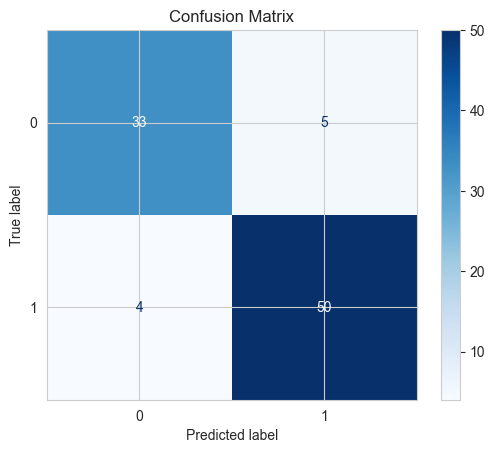

In [18]:
# Plot confusion matrix
viz.confusion_matrix_plot(y_test, y_pred_random)

- Equal proportion of **Type I** and **Type II** errors
- High prediction

In [29]:
# Save the model
filename = 'random_forest_model.pkl'
cm.save_model_to_pickle(pipeline, filename)

Model saved as /Users/martavera/IRONHACK/DSML/W6/mid-project-dsml/utils/../models/random_forest_model.pkl


### SVM Model

In [20]:
# Check with the baseline model which is the best test size
model_SVC = SVC()
cm.classification_metrics(X, y, hd_df, random_state, model_SVC, smote, preprocessor)

10.0% test size
100% of our data: 918.
90.0% for training data: 826.
10.0% for test data: 92.

20.0% test size
100% of our data: 918.
80.0% for training data: 734.
20.0% for test data: 184.

30.0% test size
100% of our data: 918.
70.0% for training data: 642.
30.0% for test data: 276.

40.0% test size
100% of our data: 918.
60.0% for training data: 550.
40.0% for test data: 368.



,test_size,accuracy,precision,recall,f1
0,10.0%,0.870,0.875,0.907,0.891
1,20.0%,0.859,0.893,0.860,0.876
2,30.0%,0.866,0.904,0.866,0.885
3,40.0%,0.864,0.913,0.855,0.883


##### Best Test Size: 10%

In [21]:
# Split the data into train and test sets with a test size of 0.3
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X, y, test_size=0.1, random_state=42)

In [22]:
# Create a Random Forest classifier
model_svc = SVC() #kernel='rbf', gamma=0.1)

In [23]:
# Create a pipeline for preprocessing 
pipeline_svc = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing 
    ('classifier', model_svc)  # SVC classifier
])

# Perform cross-validation manually, applying SMOTE only to the training data
X_train_resampled_svc, y_train_resampled_svc = smote.fit_resample(X_train_svc, y_train_svc)

# Perform cross-validation on resampled training data
cv_scores_svc = cross_val_score(pipeline_svc, X_train_resampled_svc, y_train_resampled_svc, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Average Accuracy from CV: {np.mean(cv_scores_svc):.4f} ± {np.std(cv_scores_svc):.4f}")

Average Accuracy from CV: 0.8778 ± 0.0348


In [24]:
# Now fit the model on the entire resampled training set (using the pipeline)
pipeline_svc.fit(X_train_resampled_svc, y_train_resampled_svc)

# After training, make predictions on the test set
y_pred_svc = pipeline_svc.predict(X_test_svc)

# Evaluate the performance on the test set (outside of cross-validation)
print("Test Set Evaluation:")
print(classification_report(y_test_svc, y_pred_svc))

Test Set Evaluation:


              precision    recall  f1-score   support

           0       0.89      0.82      0.85        38
           1       0.88      0.93      0.90        54

    accuracy                           0.88        92
   macro avg       0.88      0.87      0.88        92
weighted avg       0.88      0.88      0.88        92



<Figure size 800x600 with 0 Axes>

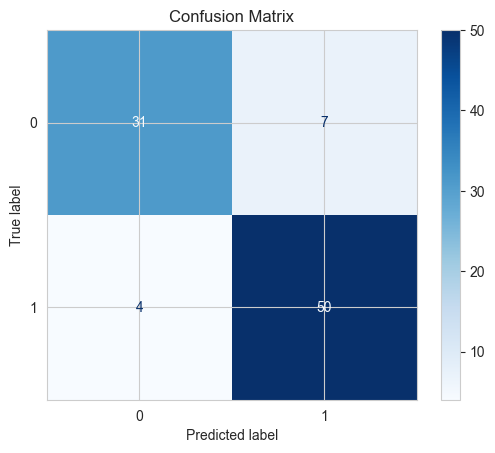

In [25]:
# Plot confusion matrix
viz.confusion_matrix_plot(y_test_svc, y_pred_svc)

- High Type I errors

- High prediction for Heart disease

In [28]:
# Save the model
filename = 'svm_model.pkl'
cm.save_model_to_pickle(pipeline_svc, filename)

Model saved as /Users/martavera/IRONHACK/DSML/W6/mid-project-dsml/utils/../models/svm_model.pkl


### Selecting a Model: ROC Curve

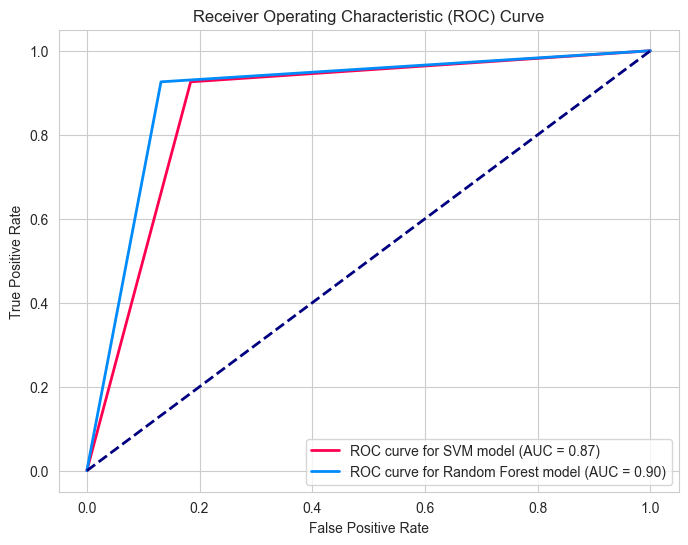

In [27]:
# Compare the ROC curve for each model
# Set the labels
label1 = 'ROC curve for SVM model'
label2 = 'ROC curve for Random Forest model'

# Plot the ROC curve
viz.roc_curve_auc_plot(y_test_svc, y_pred_svc, y_test, y_pred_random,label1, label2)

Based on the **ROC curve** we can conclude:

- The best model for our dataset is **Random Forest**.

- Random Forest has a bigger AUC, making it a better model.

- The diagonal line shows where the True Positive Rate is equal to the False Positive Rate. If the ROC curve lies above the diagonal line, the model is better than random guessing.